In [1]:
import ffmpeg

import sys
from pprint import pprint # for printing Python dictionaries in a human-readable way

In [2]:
file_path = '../video_data/cvlabrpi1/video_13.mp4'

In [3]:
print(ffmpeg.probe(file_path))

{'streams': [{'index': 0, 'codec_name': 'h264', 'codec_long_name': 'H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10', 'profile': 'High', 'codec_type': 'video', 'codec_tag_string': 'avc1', 'codec_tag': '0x31637661', 'width': 1920, 'height': 1080, 'coded_width': 1920, 'coded_height': 1080, 'closed_captions': 0, 'film_grain': 0, 'has_b_frames': 0, 'pix_fmt': 'yuv420p', 'level': 40, 'chroma_location': 'left', 'field_order': 'progressive', 'refs': 1, 'is_avc': 'true', 'nal_length_size': '4', 'id': '0x1', 'r_frame_rate': '30/1', 'avg_frame_rate': '350000000/11666677', 'time_base': '1/1200000', 'start_pts': 0, 'start_time': '0.000000', 'duration_ts': 735000651, 'duration': '612.500543', 'bit_rate': '5874054', 'bits_per_raw_sample': '8', 'extradata_size': 54, 'disposition': {'default': 1, 'dub': 0, 'original': 0, 'comment': 0, 'lyrics': 0, 'karaoke': 0, 'forced': 0, 'hearing_impaired': 0, 'visual_impaired': 0, 'clean_effects': 0, 'attached_pic': 0, 'timed_thumbnails': 0, 'non_diegetic': 0, 'captions

In [4]:
timestamp = ffmpeg.probe(
        file_path,
        select_streams='v:0',
        show_entries='packet=pts_time,flags',
        loglevel='error'
    )

In [5]:
print(timestamp.keys())

dict_keys(['packets', 'streams', 'format'])


In [6]:
print(len(timestamp['packets']))

18375


In [7]:
timestamp['packets'][0]


{'pts_time': '0.000000', 'flags': 'K__'}

In [8]:
prev_pts_time = 0
pts_dif = []
for pts_dic in  timestamp['packets'][1:]:
    pts_time = float(pts_dic['pts_time'])
    pts_dif.append(pts_time - prev_pts_time)
    prev_pts_time = pts_time

#count unique values of pts_dif
from collections import Counter
print(Counter(pts_dif))

Counter({0.03333299999999895: 6727, 0.033332999999970525: 5931, 0.03333300000002737: 4124, 0.03333300000008421: 782, 0.03333300000000072: 164, 0.033332999999999835: 143, 0.03333300000000605: 143, 0.03333300000001316: 143, 0.0333330000000025: 142, 0.03333300000000006: 30, 0.03333300000000028: 22, 0.033333: 10, 0.033332999999999946: 9, 0.04: 1, 0.033332999999999995: 1, 0.033333000000000015: 1, 0.033332999999999974: 1})


In [9]:



# uses ffprobe command to extract all possible metadata from the media file
pprint(ffmpeg.probe(file_path))

{'format': {'bit_rate': '5876542',
            'duration': '612.500543',
            'filename': '../video_data/cvlabrpi1/video_13.mp4',
            'format_long_name': 'QuickTime / MOV',
            'format_name': 'mov,mp4,m4a,3gp,3g2,mj2',
            'nb_programs': 0,
            'nb_streams': 1,
            'probe_score': 100,
            'size': '449923170',
            'start_time': '0.000000',
            'tags': {'compatible_brands': 'isomiso2avc1iso6mp41',
                     'creation_time': '2024-01-17T08:25:05.000000Z',
                     'encoder': 'Lavf58.29.100',
                     'major_brand': 'isom',
                     'minor_version': '512'}},
 'streams': [{'avg_frame_rate': '350000000/11666677',
              'bit_rate': '5874054',
              'bits_per_raw_sample': '8',
              'chroma_location': 'left',
              'closed_captions': 0,
              'codec_long_name': 'H.264 / AVC / MPEG-4 AVC / MPEG-4 part 10',
              'codec_name': 'h264

In [9]:
from ipywidgets import interact
from matplotlib import pyplot as plt
import ffmpeg
import ipywidgets as widgets
import numpy as np

In [11]:
from fractions import Fraction

def get_video_info(file_pa):

    probe = ffmpeg.probe(file_pa)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')
    # pprint(video_info)
    width = int(video_info['width'])
    height = int(video_info['height'])

    duration = float(video_info['duration'])
    frame_rate = float(Fraction(video_info['r_frame_rate']))

    num_frames = int(duration * frame_rate)
    
    return video_info, num_frames

file_path = '../video_data/cvlabrpi1/video_13.mp4'
get_video_info(file_path)[1]


18375

In [18]:
from datetime import datetime, timedelta, date
from fractions import Fraction

def get_all_timestamp_from_stream(file_path, start_time, offset_sec=0):
    """Get all timestamps of a video file
    Args:
        file_path (str): path to video file
        start_time (float): start time of the video datetime object
        offset_sec (float): offset time in seconds

    """
    timestamp = ffmpeg.probe(
        file_path,
        select_streams='v:0',
        show_entries='packet=pts_time,flags',
        loglevel='error'
    )

    time_stamps = []
    for pts_dic in  timestamp['packets']:
        pts_time = float(pts_dic['pts_time']) + offset_sec
        pts_time = start_time + timedelta(seconds=pts_time)
        pts_time = pts_time.time()
        time_stamps.append(pts_time)

    return time_stamps


def get_all_timestamp_from_rpi(file_path, start_time, offset_sec=0):
    pts_file = file_path.replace('.mp4', '.txt')

    with open(pts_file, 'r') as f:
        lines = f.readlines()

    time_stamps = []
    prev_gloabl_time = -1
    prev_relative_time = -1
    start_time = None
    for line in lines[1:]:
        global_time, relative_time = line.split(",")
        relative_time = float(relative_time)

        if start_time is None:
            start_time = datetime.fromtimestamp(int(global_time) / 1e9)

        # if relative_time < 0:
        #     prev_relative_time = relative_time
        #     prev_gloabl_time = global_time
        #     continue

        # if prev_relative_time < 0:
        #     prev_relative_time = None
        #     global_time = datetime.datetime.fromtimestamp(int(global_time) / 1e9)

        #     time_stamps.append(start_time + timedelta(seconds=relative_time))

        global_time = start_time + timedelta(milliseconds=relative_time)
        pts_time = global_time.time()
        time_stamps.append(pts_time)

    return time_stamps


def get_all_timestamp_from_framerate(file_path, start_time, offset_sec=0):
    """Get all timestamps of a video file
    Args:
        file_path (str): path to video file
        start_time (float): start time of the video datetime object
        offset_sec (float): offset time in seconds

    """
    probe = ffmpeg.probe(file_path)
    video_info = next(s for s in probe['streams'] if s['codec_type'] == 'video')

    duration = float(video_info['duration'])
    frame_rate = float(Fraction(video_info['r_frame_rate']))

    num_frames = int(duration * frame_rate)

    time_stamps = []
    for frame in range(num_frames):
        pts_time = frame / frame_rate + offset_sec
        #remove date keep only time
        pts_time = (start_time + timedelta(seconds=pts_time))
        pts_time = pts_time.time()
        time_stamps.append(pts_time)

    return time_stamps

file_path = '../video_data/cvlabrpi1/video_52.mp4'

video_info, nb_frames = get_video_info(file_path)
start_time = datetime.strptime(video_info["tags"]["creation_time"], '%Y-%m-%dT%H:%M:%S.%fZ')
offset_sec = 0

tmps_ffprob = get_all_timestamp_from_stream(file_path, start_time, offset_sec=offset_sec)
tmps_rpi = get_all_timestamp_from_rpi(file_path, start_time, offset_sec=offset_sec)
tmps_framerate = get_all_timestamp_from_framerate(file_path, start_time, offset_sec=offset_sec)

print(len(tmps_ffprob))
print(len(tmps_rpi))
print(len(tmps_framerate))



21151
21152
21143


In [32]:
print(file_path)

../video_data/cvlabrpi1/video_13.mp4


In [19]:
def get_frame(file_path, frame_number, width, height):
    out, err = (
        ffmpeg
        .input(file_path)
        .filter_('select', 'gte(n,{})'.format(frame_number))
        .output('pipe:', format='rawvideo', pix_fmt='rgb24', vframes=1)
        .run(capture_stdout=True, capture_stderr=True)
    )
    frame = (
        np
        .frombuffer(out, np.uint8)
        .reshape([height, width, 3])
    )
    return frame

def visualize_frame_and_timestamp(file_path):

    video_info, num_frames = get_video_info(file_path)
    start_time = datetime.strptime(video_info["tags"]["creation_time"], '%Y-%m-%dT%H:%M:%S.%fZ')
    
    width = int(video_info['width'])
    height = int(video_info['height'])

    tmps_ffprob = get_all_timestamp_from_stream(file_path, start_time, offset_sec=offset_sec)
    tmps_rpi = get_all_timestamp_from_rpi(file_path, start_time, offset_sec=offset_sec)
    tmps_framerate = get_all_timestamp_from_framerate(file_path, start_time, offset_sec=offset_sec)

    # @interact(frame=(0, num_frames-1), offset_sec=(-10, 10, 1), offset_milli_sec=(-1000, 1000, 100))
    def show_frame(frame=0, offset_sec=0, offset_milli_sec=0):
        plt.figure(figsize=(15,15))
        plt.imshow(get_frame(file_path, frame, width, height))
        plt.title(f"frame {frame} - \n ffp: {(datetime.combine(date(1,1,1),tmps_ffprob[frame]) + timedelta(seconds=offset_sec, milliseconds=offset_milli_sec)).time()}, \n rpi: {(datetime.combine(date(1,1,1),tmps_rpi[frame]) + timedelta(seconds=offset_sec, milliseconds=offset_milli_sec)).time()}, \n fra: {(datetime.combine(date(1,1,1),tmps_framerate[frame]) + timedelta(seconds=offset_sec, milliseconds=offset_milli_sec)).time()},")
        #     plt.imshow(get_frame(file_path, frame, width, height))
        plt.axis('off')  # to hide the axis values
        plt.show()

    return interact(show_frame, frame=(0, num_frames-1), offset_sec=(-10, 10, 1), offset_milli_sec=(-1000, 1000, 1))

file_path = '../video_data/cvlabrpi1/video_52.mp4'
visualize_frame_and_timestamp(file_path)

interactive(children=(IntSlider(value=0, description='frame', max=21142), IntSlider(value=0, description='offs…

<function __main__.visualize_frame_and_timestamp.<locals>.show_frame(frame=0, offset_sec=0, offset_milli_sec=0)>

In [88]:
idx = 5000

print(tmps_ffprob[idx], tmps_rpi[idx], tmps_framerate[idx])

08:27:51.671667 08:27:54.309365 08:27:51.666667


In [66]:
video_info, duration = get_video_info(file_path)


2024-01-17T08:25:05.000000Z
2024-01-17 08:25:05


In [14]:
%matplotlib widget

In [48]:
file_path_1 = '../video_data/cvlabrpi1/video_12.mp4'
file_path_2 = '../video_data/cvlabrpi1/video_13.mp4'

In [49]:
from datetime import datetime

def get_time_offset(tms1, tms2):
    datetime1 = datetime.strptime(tms1, "%Y-%m-%dT%H:%M:%S.%fZ")
    datetime2 = datetime.strptime(tms2, "%Y-%m-%dT%H:%M:%S.%fZ")

    # Calculate the difference
    time_difference = datetime2 - datetime1

    # Get the difference in seconds
    seconds_difference = time_difference.total_seconds()
    
    return seconds_difference


In [50]:
info1, num_frames1 = get_video_info(file_path_1)
info2, num_frames2 = get_video_info(file_path_2)

# pprint(info1)

print("num_frames", num_frames1, num_frames2)
print("start_time", info1["start_time"], info2["start_time"])
print("duration", info1["duration"], info2["duration"])
print("creation_time", info1["tags"]["creation_time"], info2["tags"]["creation_time"])

num_frames 19709 18375
start_time 0.000000 0.000000
duration 656.966764 612.500543
creation_time 2024-01-17T08:10:01.000000Z 2024-01-17T08:25:05.000000Z


In [51]:
get_time_offset(info1["tags"]["creation_time"], info2["tags"]["creation_time"])

904.0

In [ ]:
def 

In [64]:
import ffmpeg
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

def get_frame(file_path, frame_number, width, height):
    out, err = (
        ffmpeg
        .input(file_path)
        .filter_('select', 'gte(n,{})'.format(frame_number))
        .output('pipe:', format='rawvideo', pix_fmt='rgb24', vframes=1)
        .run(capture_stdout=True, capture_stderr=True)
    )
    frame = (
        np
        .frombuffer(out, np.uint8)
        .reshape([height, width, 3])
    )
    return frame

width = 1920
height = 1080


@interact(frame=(0, num_frames1-1))
def show_frame(frame=0):
    plt.figure(figsize=(15,15))
    plt.imshow(get_frame(file_path_1, frame, width, height))
    #     plt.imshow(get_frame(file_path, frame, width, height))
    plt.axis('off')  # to hide the axis values
    plt.show()

interactive(children=(IntSlider(value=0, description='frame', max=19708), Output()), _dom_classes=('widget-int…

In [31]:
import ffmpeg
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

def get_frame(file_path, frame_number, width, height):
    out, err = (
        ffmpeg
        .input(file_path)
        .filter_('select', 'gte(n,{})'.format(frame_number))
        .output('pipe:', format='rawvideo', pix_fmt='rgb24', vframes=1)
        .run(capture_stdout=True, capture_stderr=True)
    )
    frame = (
        np
        .frombuffer(out, np.uint8)
        .reshape([height, width, 3])
    )
    return frame




@interact(frame=(0, num_frames2-1))
def show_frame(frame=0):
    plt.figure(figsize=(15,15))
    plt.imshow(get_frame(file_path_2, frame, width, height)[800:731:-1,1072:750:-1,:])
    #     plt.imshow(get_frame(file_path, frame, width, height))
    plt.axis('off')  # to hide the axis values
    plt.show()

interactive(children=(IntSlider(value=0, description='frame', max=5726), Output()), _dom_classes=('widget-inte…

In [ ]:
out, err = (
    ffmpeg
    .input(file_path)
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)
video = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
)

In [8]:
video.shape

(5681, 1080, 1920, 3)

interactive(children=(IntSlider(value=0, description='frame', max=5681), Output()), _dom_classes=('widget-inte…

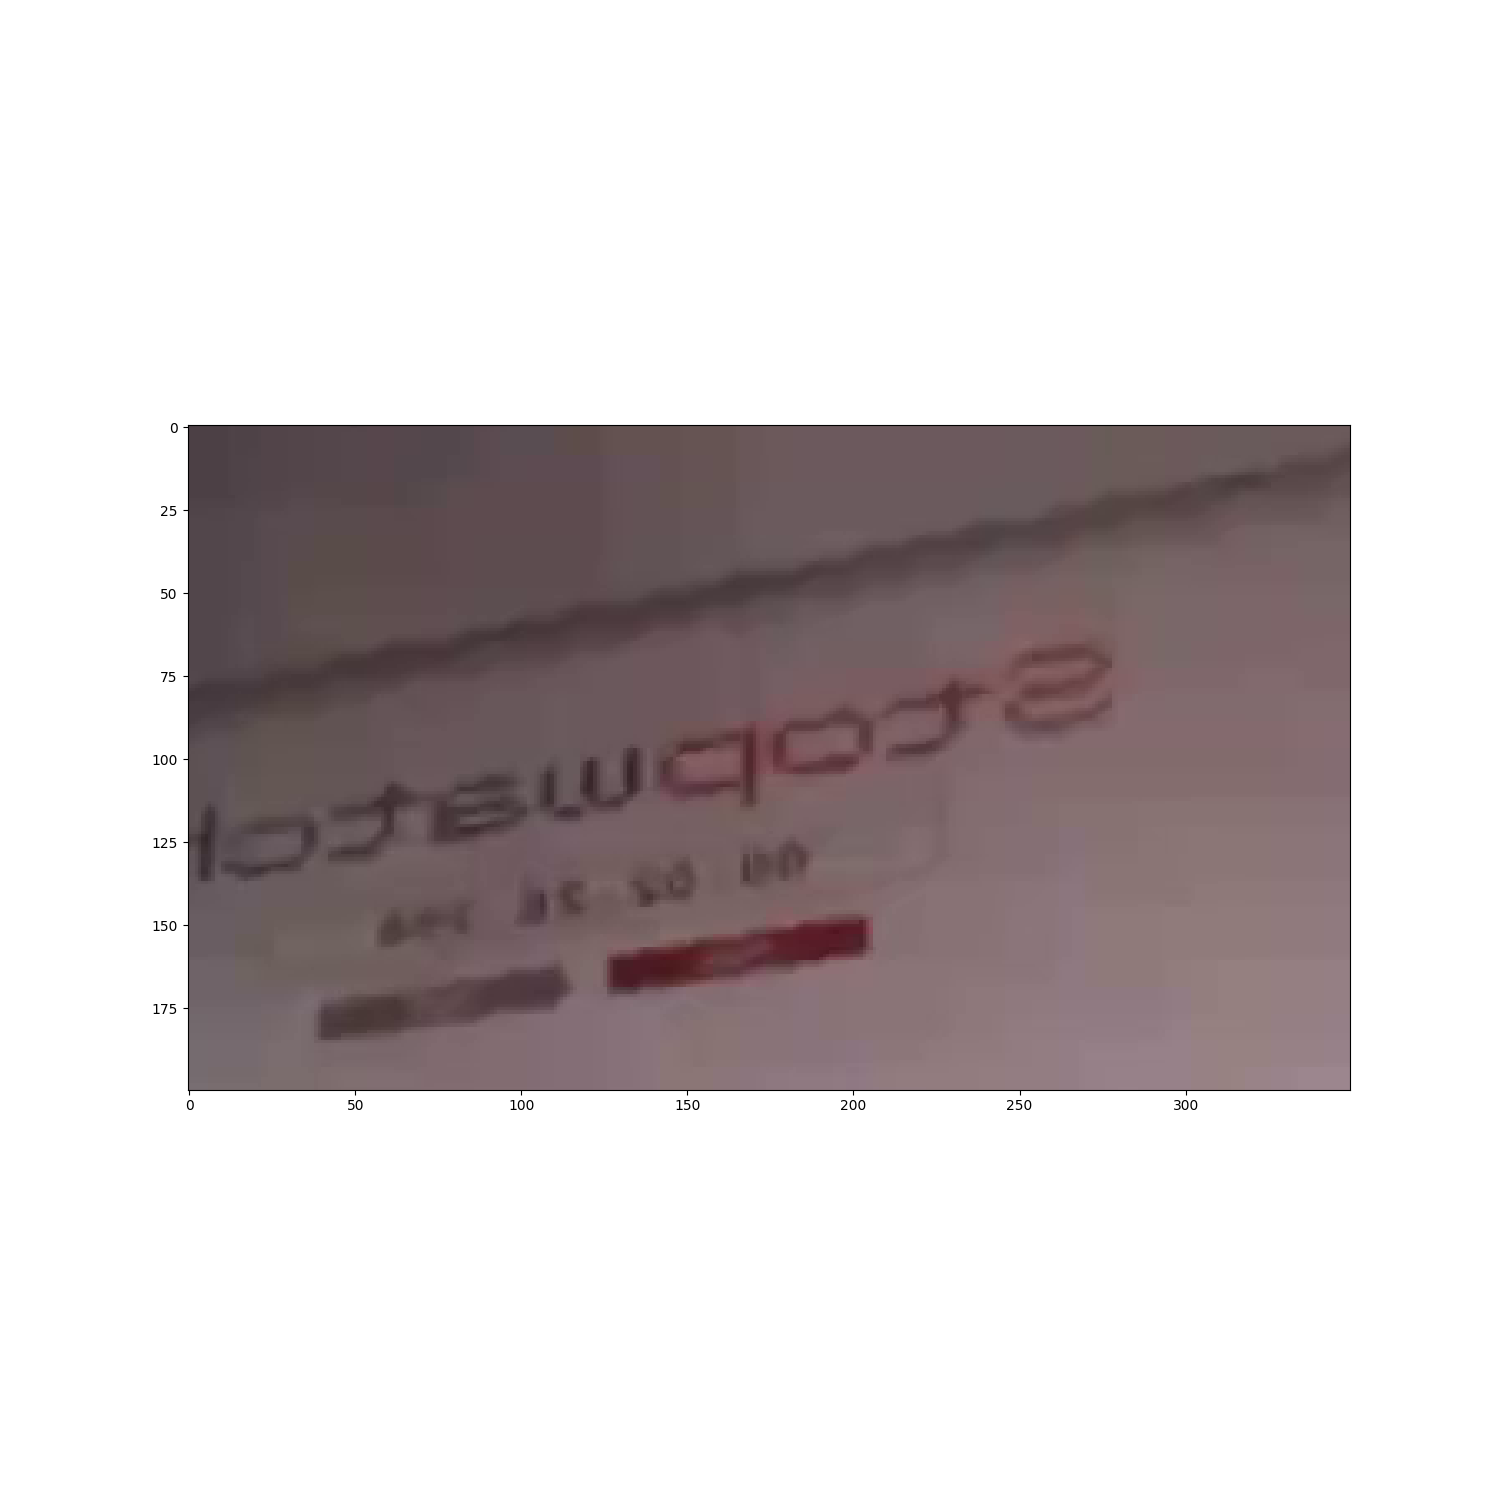

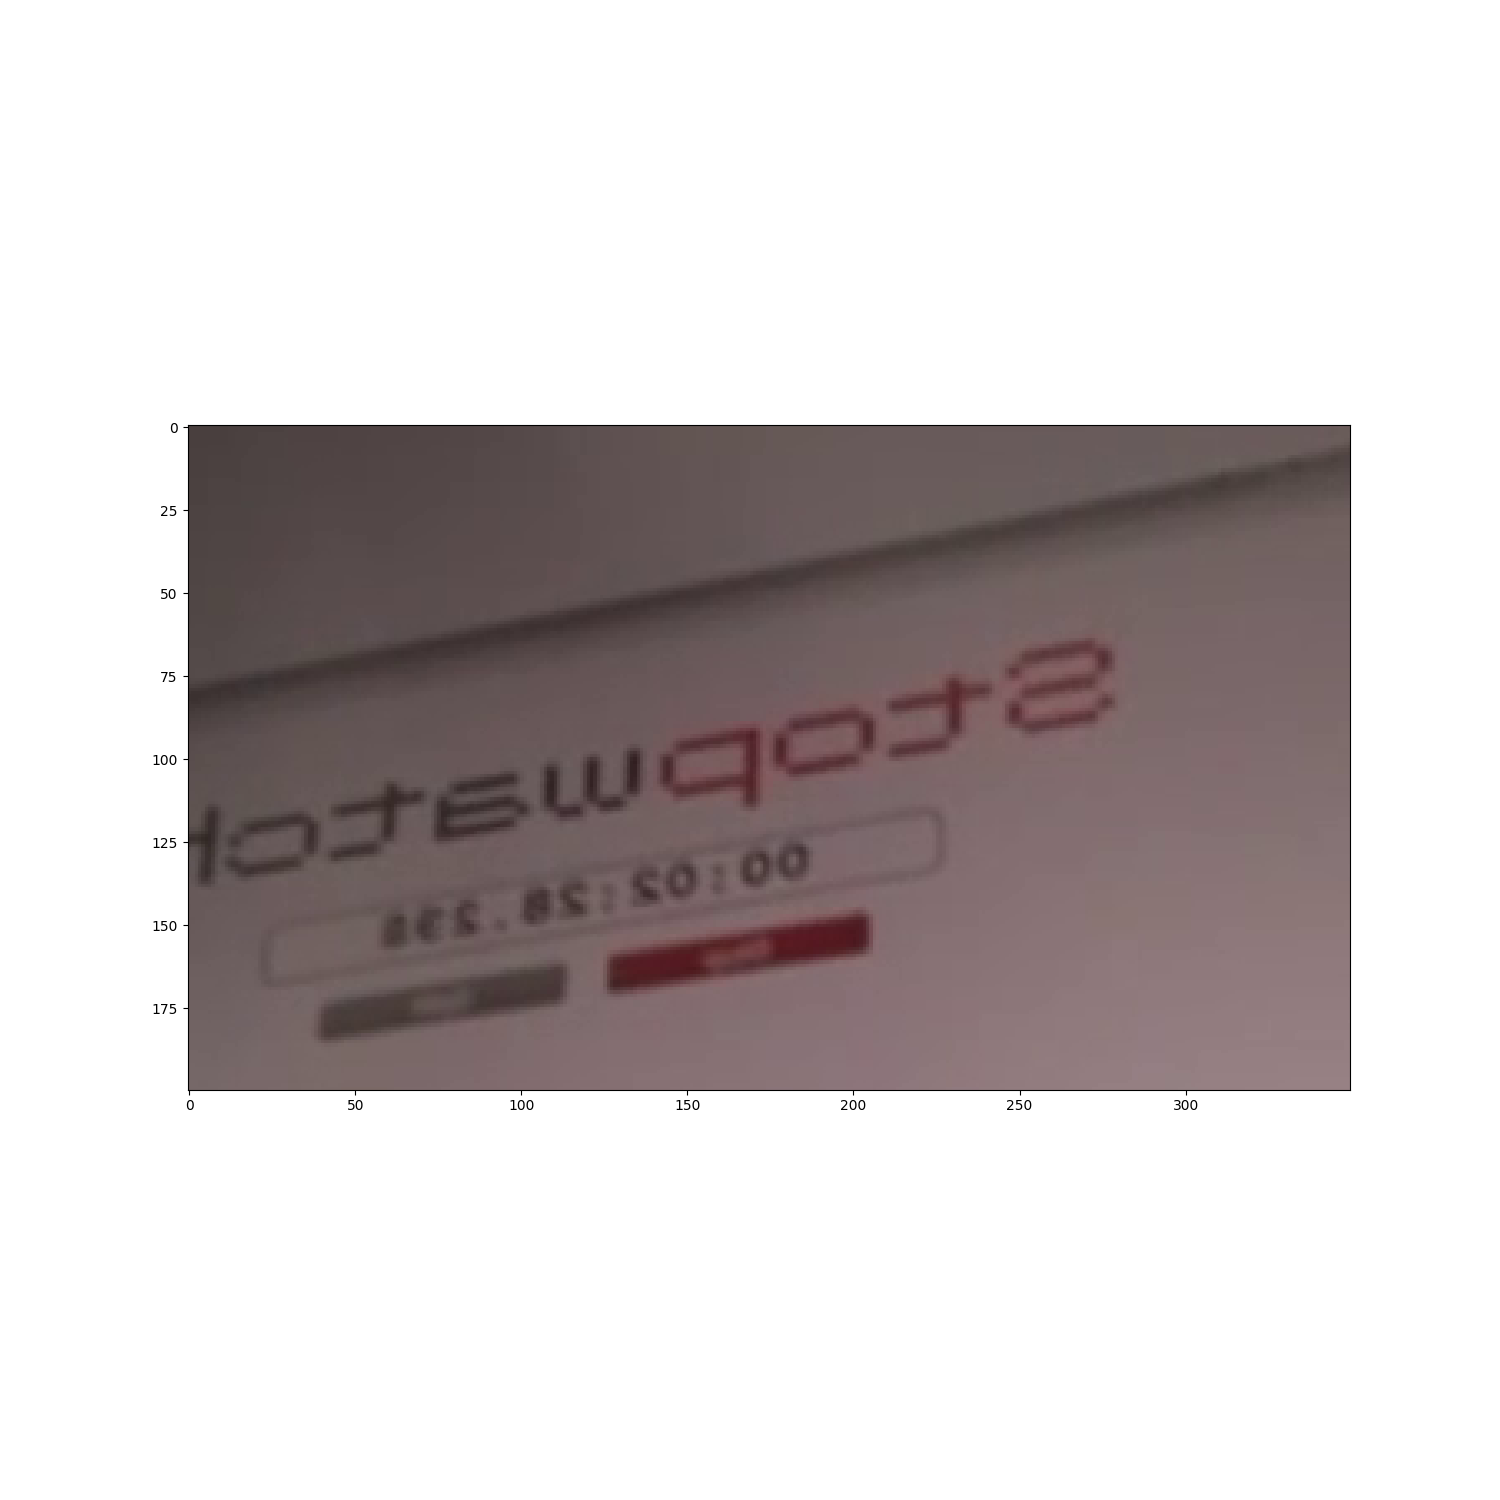

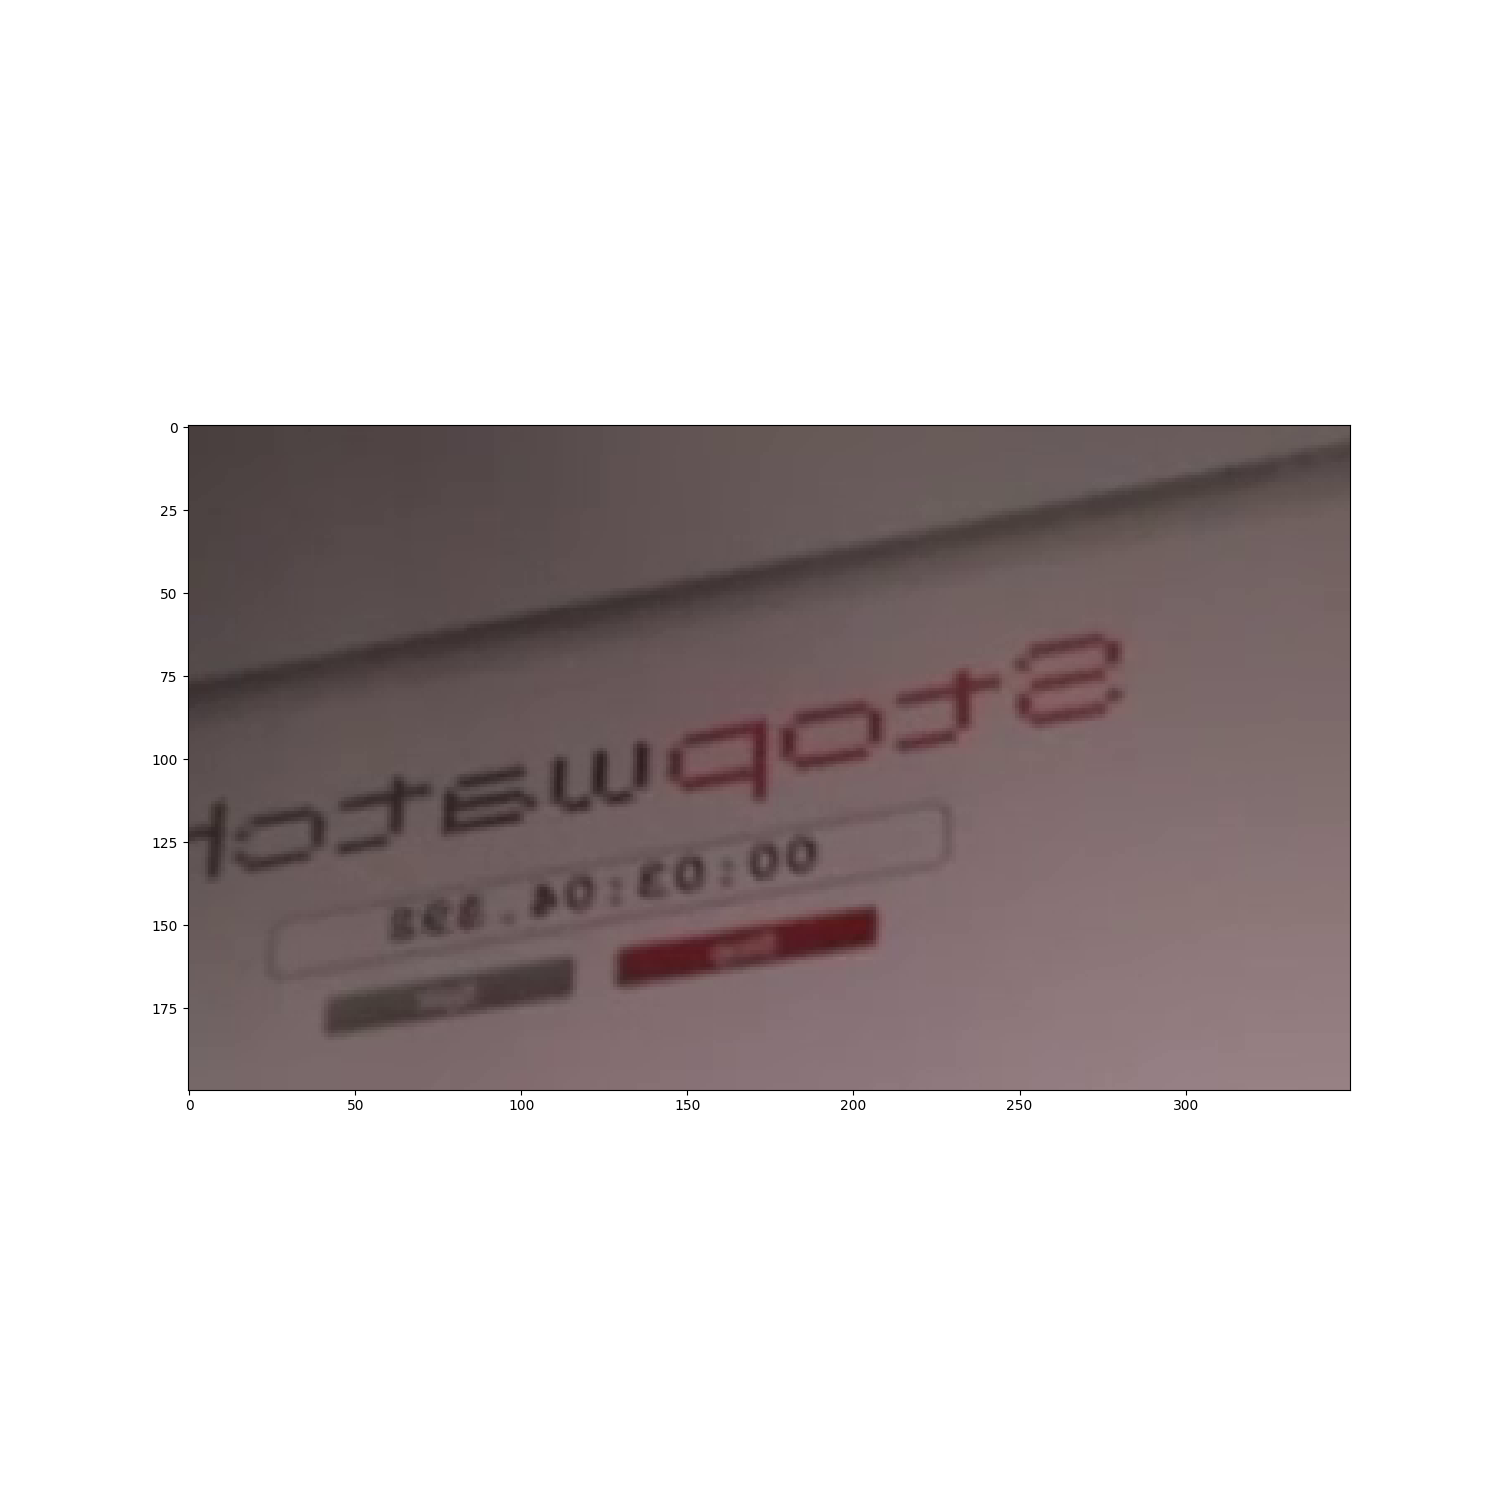

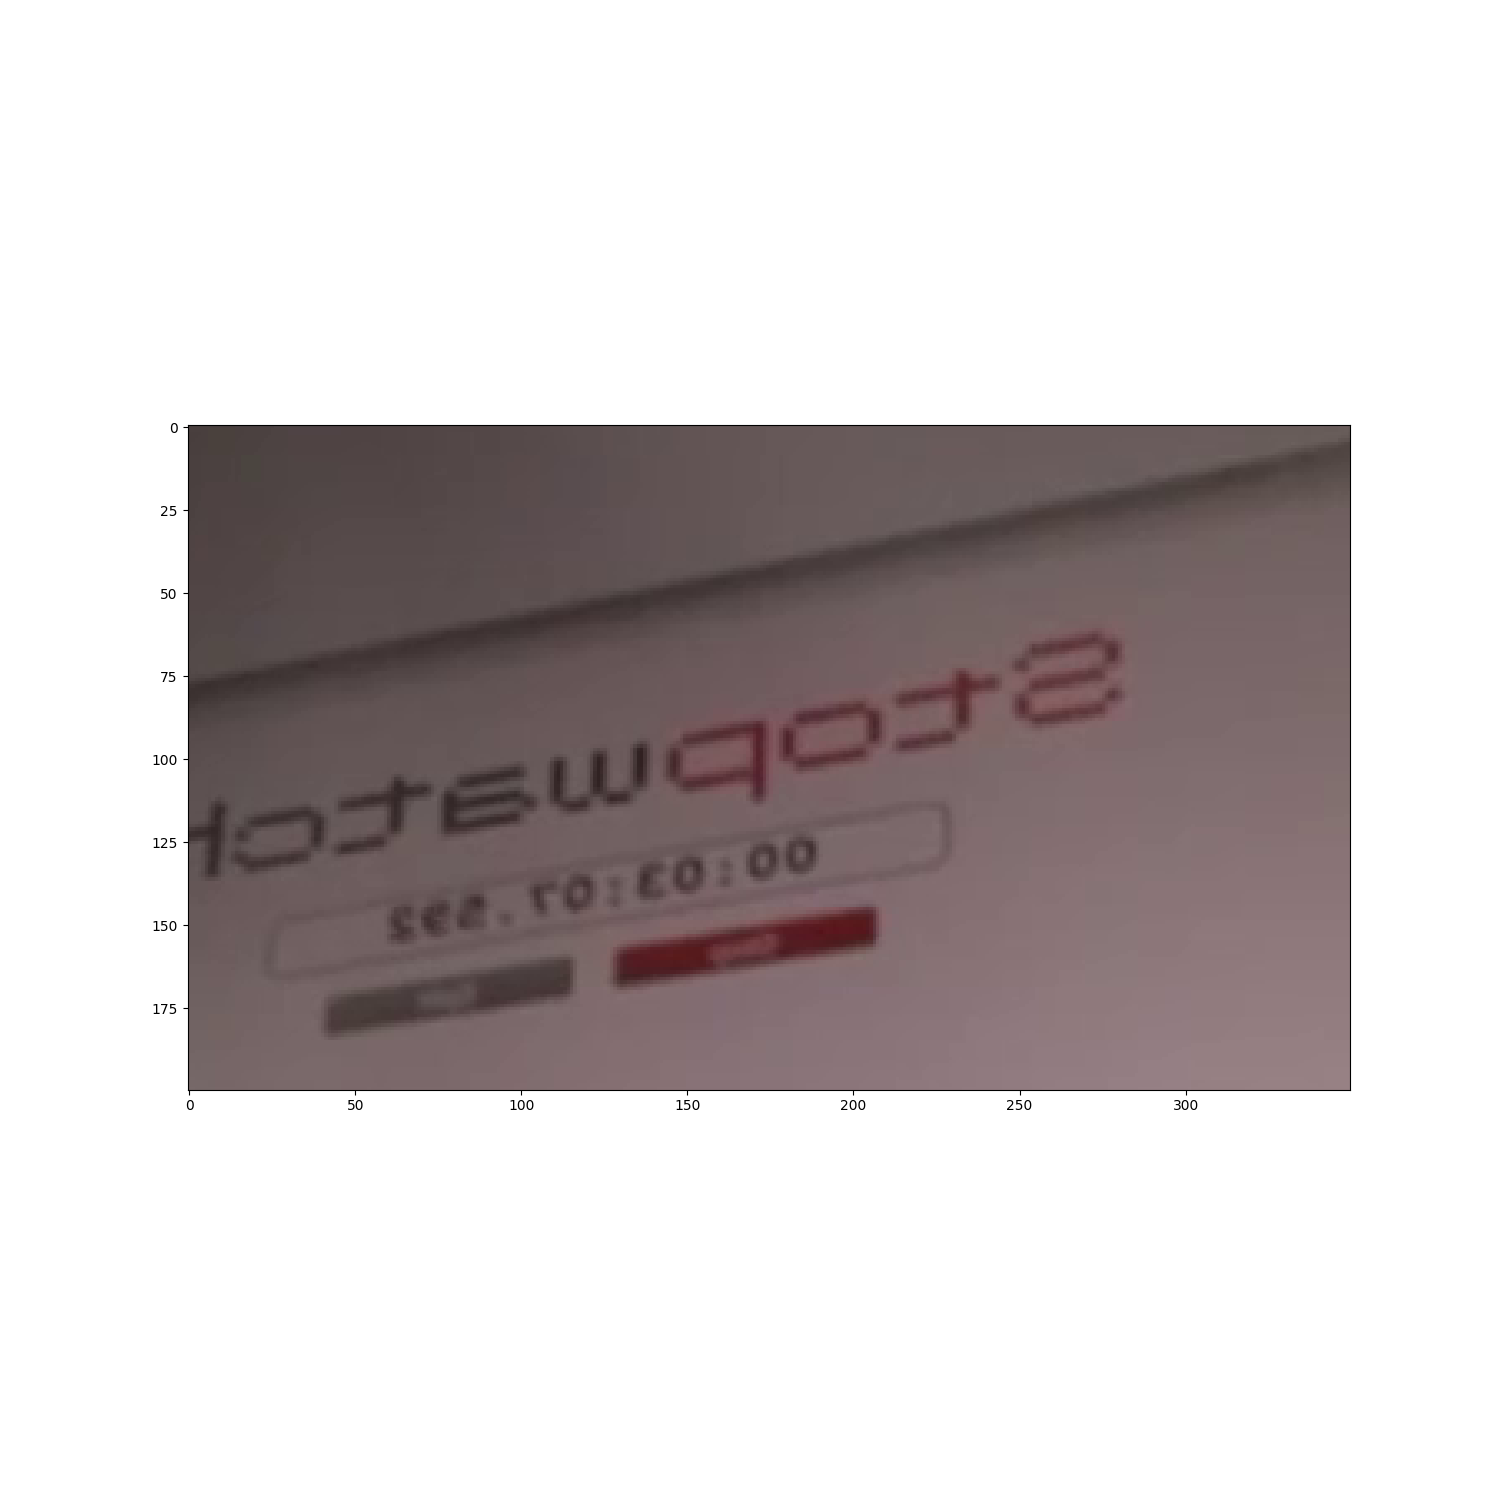

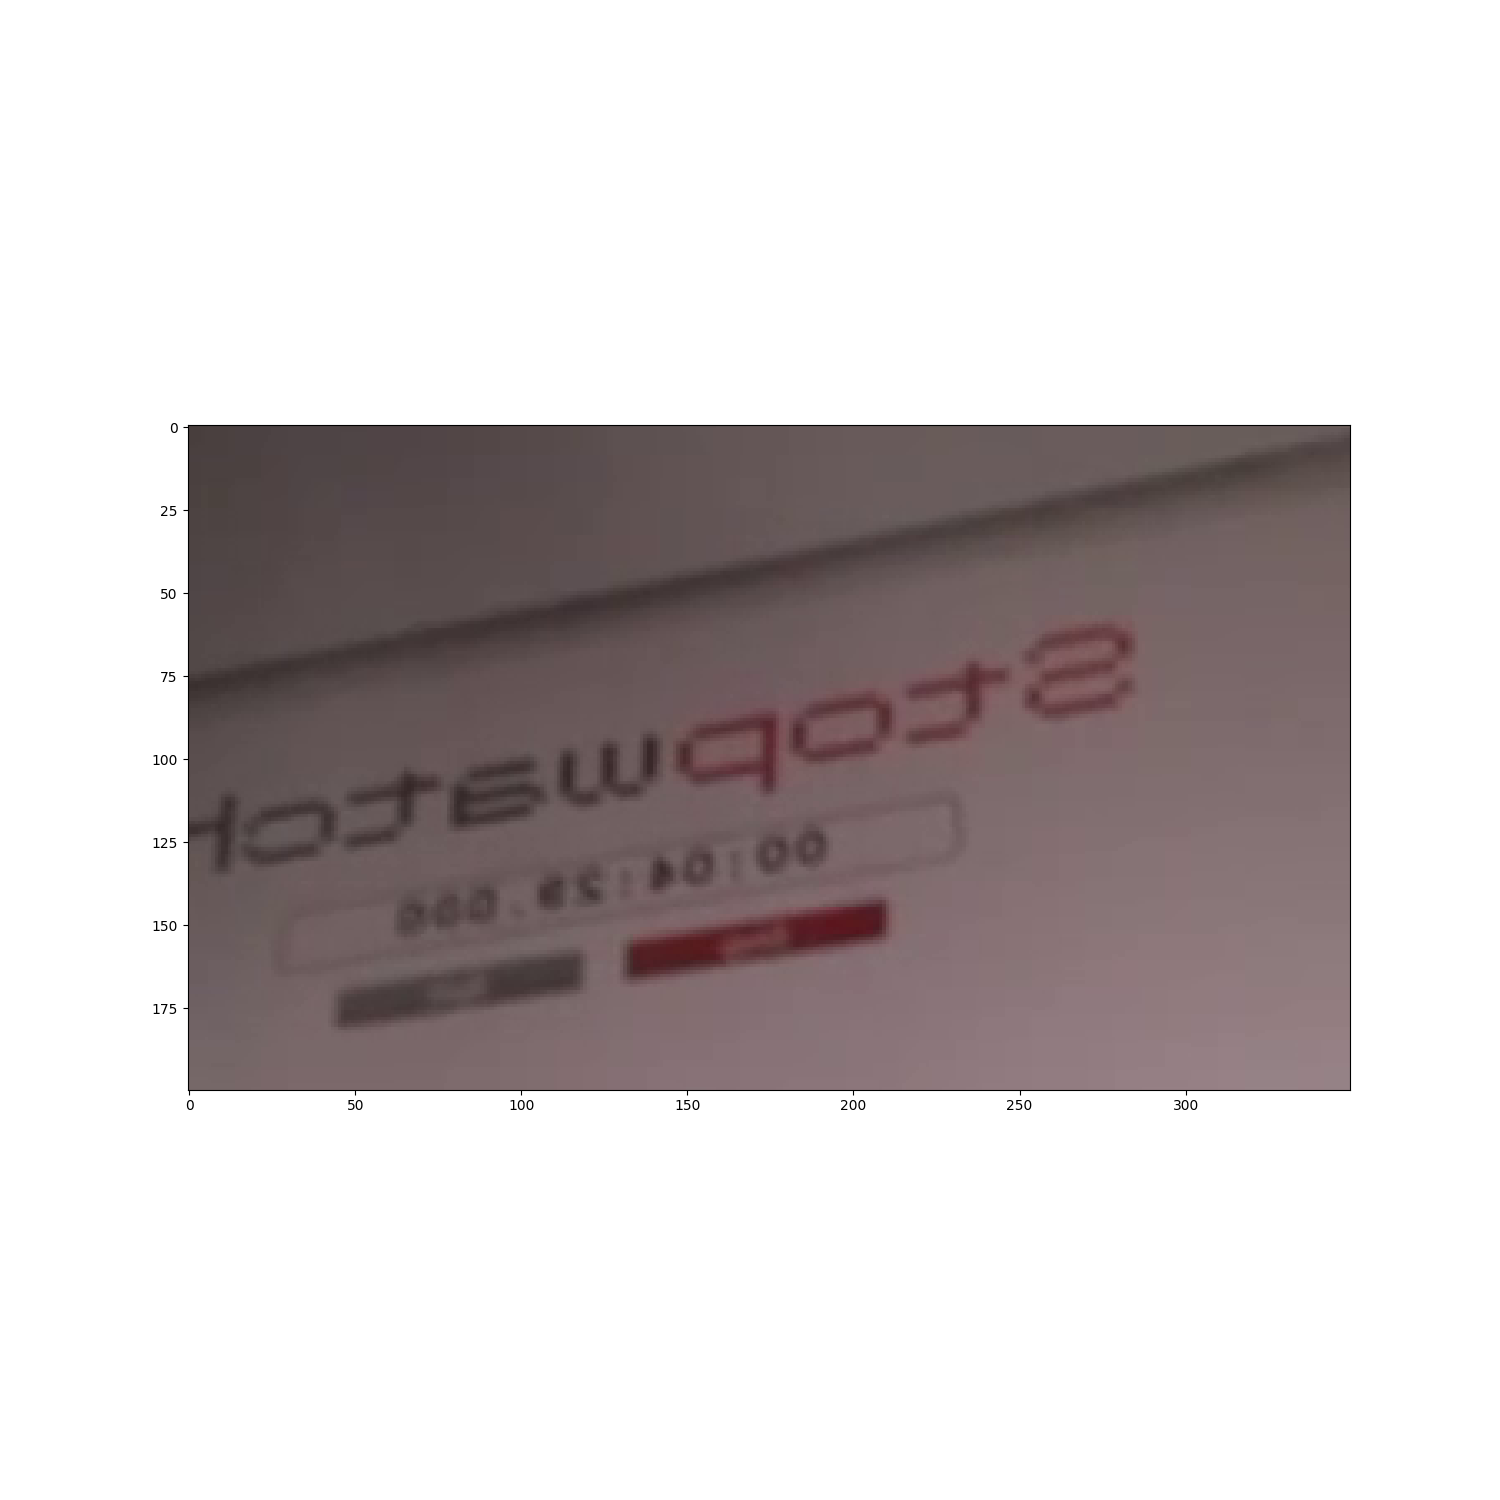

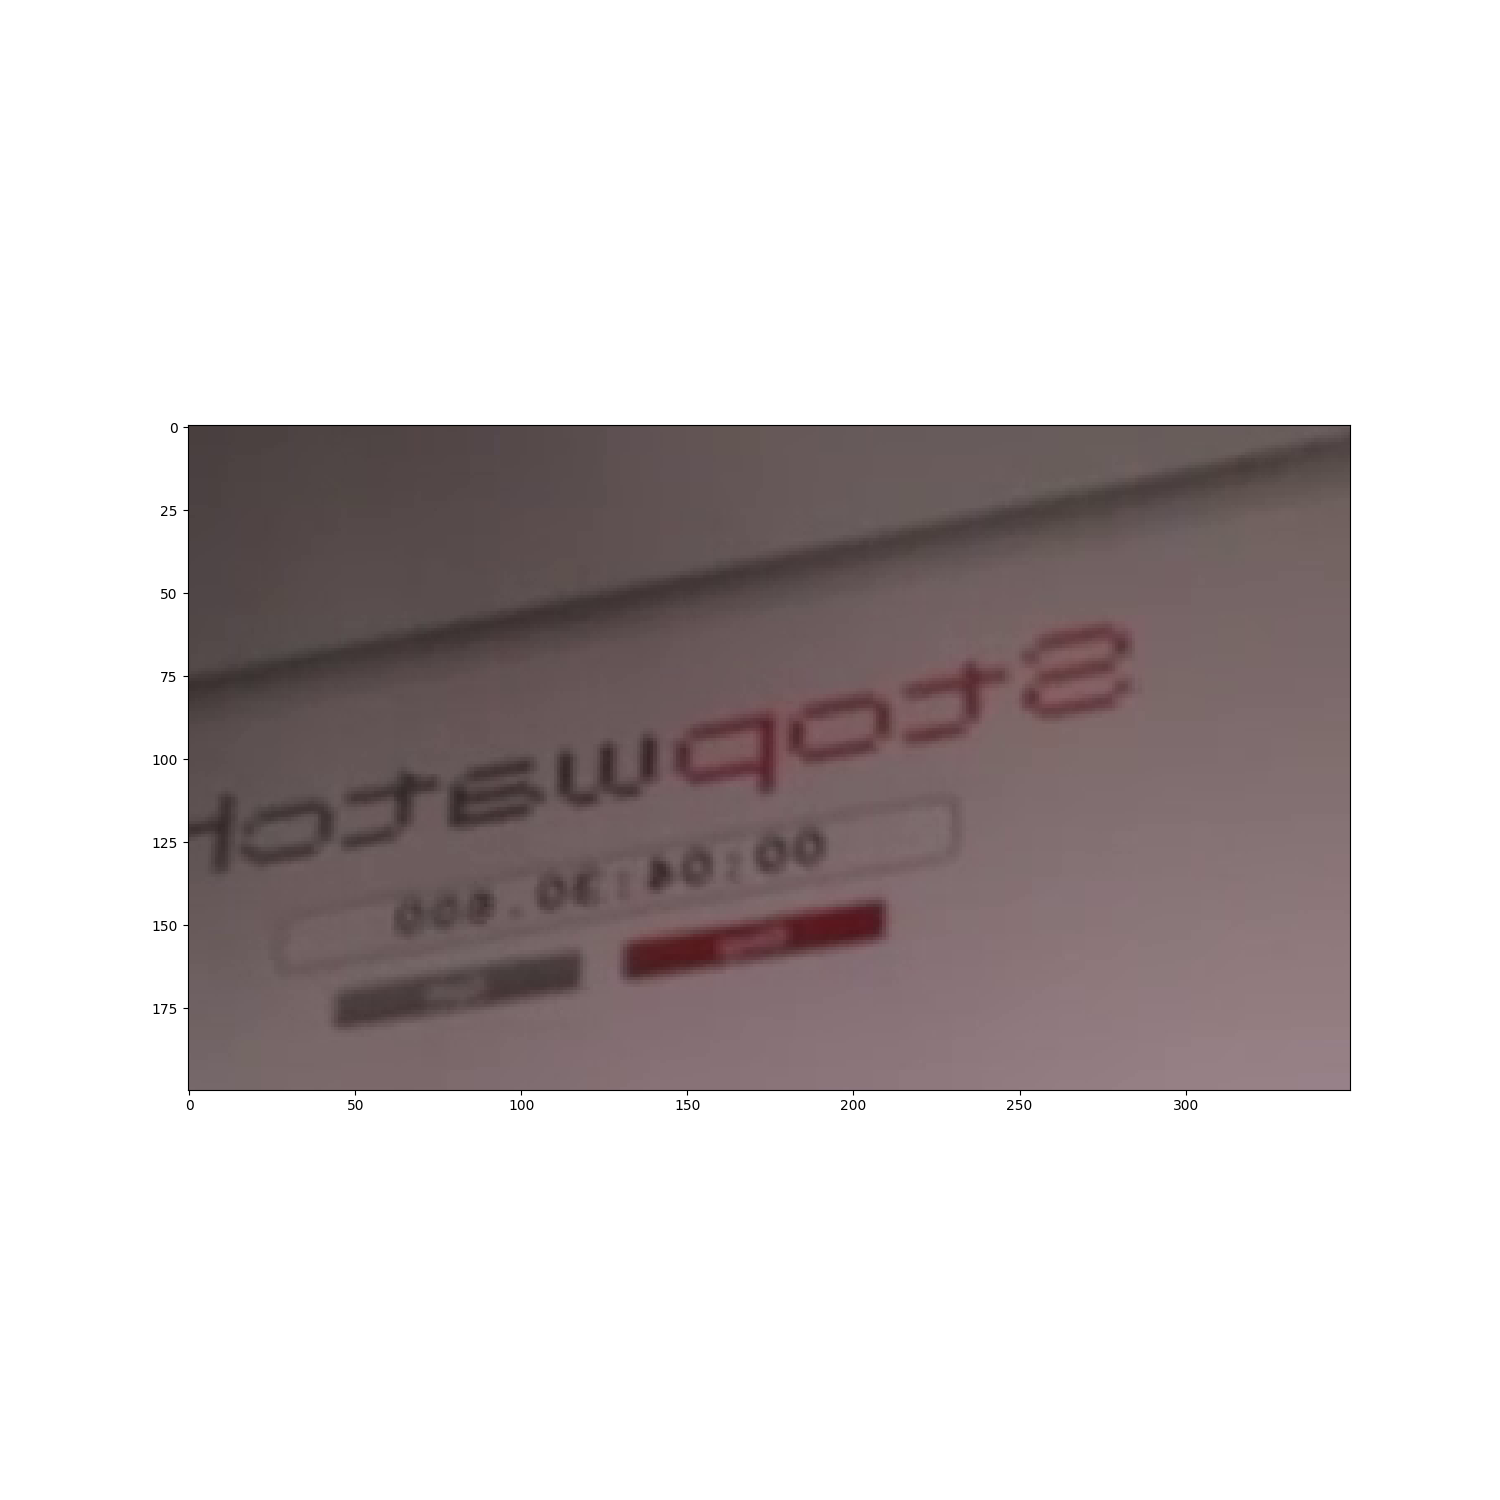

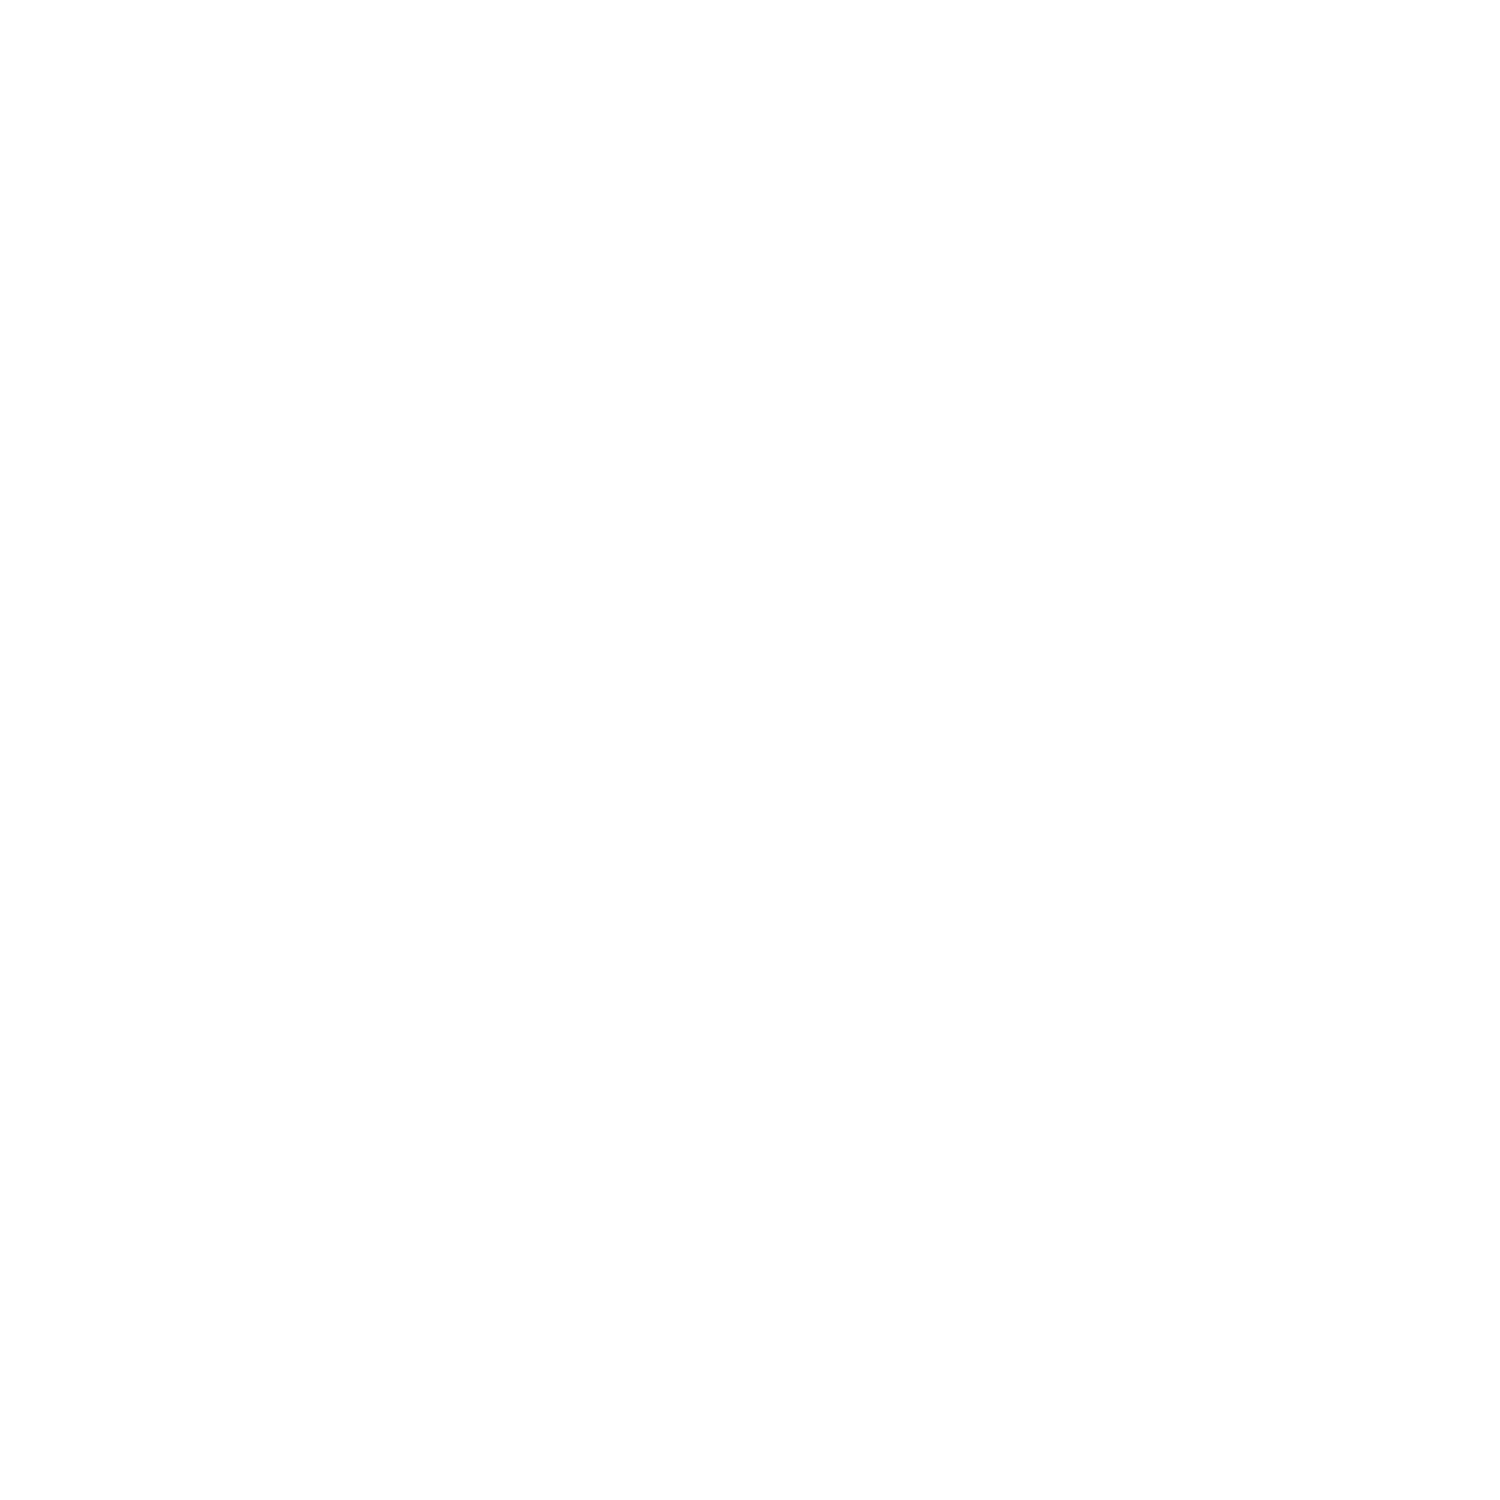

In [15]:

@interact(frame=(0, num_frames))
def show_frame(frame=0):
    plt.figure(figsize=(15,15))
    plt.imshow(video[frame,1000:800:-1,850:1200,:])